In [3]:
'''
Training Data is a N*T*n tensor, N is the number of samples, T is the interval,
n is number of neurons.
Training Data is a N*1*1 tensor, N is the number of samples, 1*1 represents the
output dimension, which is the position of last time point.
Testing Data is a N'*T*n tensor.
Testing label is a N*1*1 tensor.
E.g.,
TrainingData = create_subsequences(np.transpose(X, TimeInterval))
TrainingLabel = Y[TimeInterval-1:].reshape(-1,1)
X is dFF, Y is corresponding position.
'''

"\nTraining Data is a N*T*n tensor, N is the number of samples, T is the interval,\nn is number of neurons.\nTraining Data is a N*1*1 tensor, N is the number of samples, 1*1 represents the\noutput dimension, which is the position of last time point.\nTesting Data is a N'*T*n tensor.\nTesting label is a N*1*1 tensor.\nE.g.,\nTrainingData = create_subsequences(np.transpose(X, TimeInterval))\nTrainingLabel = Y[TimeInterval-1:].reshape(-1,1)\nX is dFF, Y is corresponding position.\n"

In [39]:
import torch, os, glob
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)
import scipy, pandas as pd, random
from sklearn.preprocessing import MinMaxScaler

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim = 256, 
        output_dim = 1, 
        num_layers = 2):
        # hidden_dim = height of network
        # layers = wifth of network
        super(LSTMModel, self).__init__()
        # Initialize the LSTM, Hidden Layer, and Output Layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                dropout = 0.0, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        
        return out

def create_subsequences(time_series, subsequence_length=20):
    num_subsequences = len(time_series) - subsequence_length + 1
    subsequences = [time_series[i:i+subsequence_length] for i in range(num_subsequences)]
    return np.array(subsequences)

class CreateTimeSeriesData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [40]:
# import raw data
with open("Z:\dcts_com_opto_inference.p", "rb") as fp: #unpickle
        dcts = pickle.load(fp)
conddf = pd.read_csv(r"Z:\condition_df\conddf_neural_com_inference.csv", index_col=None)

In [35]:
dd=4
animal = conddf.animals.values[dd]
day = conddf.days.values[dd]
savepth = rf'Z:\models_lstm_all_cells_no_rew'   
testpth = glob.glob(os.path.join(savepth, f'model_dd{dd:02d}*_{animal}_day{day}*'), recursive=True)
dct = dcts[dd]
params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane0_Fall.mat"
print(params_pth)
fall = scipy.io.loadmat(params_pth, variable_names=['dFF', 'forwardvel', 'ybinned', 'iscell',
                            'trialnum', 'bordercells', 'changeRewLoc', 'licks', 'VR'])
VR = fall['VR'][0][0]
print(VR.dtype)
gainf = VR[15][0][0]
print(gainf)
print(VR[17][0][0][4][0][0])
    # gainf = VR[14][0][0]
    # rewsize = VR[16][0][0][4][0][0]/gainf

Y:\analysis\fmats\e218\days\e218_day035_plane0_Fall.mat


[('name_date_vr', 'O'), ('ROE', 'O'), ('lickThreshold', 'O'), ('reward', 'O'), ('time', 'O'), ('lick', 'O'), ('ypos', 'O'), ('lickVoltage', 'O'), ('trialNum', 'O'), ('timeROE', 'O'), ('optoTrigger', 'O'), ('changeRewLoc', 'O'), ('pressedKeys', 'O'), ('world', 'O'), ('imageSync', 'O'), ('scalingFACTOR', 'O'), ('wOff', 'O'), ('settings', 'O')]
0.6666666666666666
6.666666666666666


In [41]:
# make models for all animals/days
for dd in range(len(conddf)): 
    animal = conddf.animals.values[dd]
    day = conddf.days.values[dd]
    savepth = rf'Z:\models_lstm_all_cells_no_rew'   
    testpth = glob.glob(os.path.join(savepth, f'model_dd{dd:03d}*_{animal}_day{day}*'), recursive=True)
    if len(testpth)==0:             
        dct = dcts[dd]
        params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane0_Fall.mat"
        print(params_pth)
        fall = scipy.io.loadmat(params_pth, variable_names=['dFF', 'forwardvel', 'ybinned', 'iscell',
                                    'trialnum', 'bordercells', 'changeRewLoc', 'licks', 'VR'])
        VR = fall['VR'][0][0]
        try:
            gainf = VR[14][0][0]
            rewsize = VR[16][0][0][4][0][0]/gainf
        except:
            gainf = VR[15][0][0] # opto days have additional variables in vr
            rewsize = VR[17][0][0][4][0][0]/gainf
        inactive = dcts[dd]['inactive']
        changeRewLoc = np.hstack(fall['changeRewLoc']) 
        eptest = conddf.optoep.values[dd]
        eps = np.where(changeRewLoc>0)[0]
        rewlocs = changeRewLoc[eps]
        eps = np.append(eps, len(changeRewLoc)) 
        if conddf.optoep.values[dd]<2: 
            eptest = random.randint(2,3)   
            if len(eps)<4: eptest = 2 # if no 3 epochs
        trialnum = np.hstack(fall['trialnum'])
        comp = [eptest-2,eptest-1] # eps to compare  
        other_ep = [xx for xx in range(len(eps)-1) if xx not in comp]
        # filter iscell        
        dff = fall['dFF'][:,(fall['iscell'][:,0].astype(bool)) & (~fall['bordercells'][0].astype(bool))]
        # position mask 
        # NOTE: excl reward location            
        position = fall['ybinned'][0]
        position_per_ep = [position[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]       
        # remove nans
        dff[:, sum(np.isnan(dff))>0] = 0
        # exclude rew zone
        dff_per_ep = [dff[eps[xx]:eps[xx+1]][(position_per_ep[xx]<rewlocs[xx]-(.5*rewsize)) | 
                (position_per_ep[xx]>rewlocs[xx]+(.5*rewsize))]
            for xx in range(len(eps)-1)]        
        trialnum_per_ep = [trialnum[eps[xx]:eps[xx+1]][(position_per_ep[xx]<rewlocs[xx]-(.5*rewsize)) | 
                (position_per_ep[xx]>rewlocs[xx]+(.5*rewsize))] for xx in range(len(eps)-1)]
        # get a subset of trials
        dff_per_ep_trials = [dff_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
        dff_per_ep_trials_test = [dff_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
        # get a subset of trials
        position_per_ep_trials = [position_per_ep[ii][(position_per_ep[ii]<rewlocs[ii]-(.5*rewsize)) |
                (position_per_ep[ii]>rewlocs[ii]+(.5*rewsize))][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
        position_per_ep_trials_test = [position_per_ep[ii][(position_per_ep[ii]<rewlocs[ii]-(.5*rewsize)) |
            (position_per_ep[ii]>rewlocs[ii]+(.5*rewsize))][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
        # licks
        licks = fall['licks'][0]
        licks_per_ep = [licks[eps[xx]:eps[xx+1]][(position_per_ep[xx]<rewlocs[xx]-(.5*rewsize)) | 
            (position_per_ep[xx]>rewlocs[xx]+(.5*rewsize))] for xx in range(len(eps)-1)]
        # get a subset of trials
        licks_per_ep_trials = [licks_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
        licks_per_ep_trials_test = [licks_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
            #prepare variables 
        TimeInterval = 15 # frames
        train = dff_per_ep_trials[comp[0]]
        print(train.shape)
        if train.shape[1]>0:
            test = dff_per_ep_trials_test[comp[0]]
            train_pos = position_per_ep_trials[comp[0]]
            TrainingLabel = train_pos[TimeInterval-1:].reshape(-1,1)
            test_pos = position_per_ep_trials_test[comp[0]]
            TestLabel = test_pos[TimeInterval-1:].reshape(-1,1)

            TrainingData = create_subsequences(train,TimeInterval)
            batch_size = 256
            input_size = TrainingData.shape[-1] # number of cells
            output_size = 1
            Train_dataset = CreateTimeSeriesData(TrainingData, TrainingLabel)
            Train_loader = DataLoader(dataset=Train_dataset, batch_size=batch_size, 
                        shuffle=True, drop_last = True)
            TestData = create_subsequences(test,TimeInterval)
            Test_dataset = CreateTimeSeriesData(TestData, TestLabel)
            Test_loader = DataLoader(dataset=Test_dataset, batch_size=batch_size,
                        shuffle=False, drop_last = True)
            
            # define the model & train
            # TODO: add transfer learning
            model = LSTMModel(input_size, output_dim = output_size)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            print(device)
            model = model.to(device)
            criterion = nn.MSELoss()  # For regression tasks
            # criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(),
                    lr=1e-5, weight_decay = 1e-9)
            # Example training loop
            l = []
            val_l = []
            num_epochs = 3000
            for epoch in range(num_epochs):
                train_loss = 0.0
                for inputs, targets in Train_loader:
                    # Forward pass
                    inputs, targets = inputs.to(device).float(), targets.to(device).float()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                l.append(train_loss/len(Train_loader))
                if epoch % 20 == 0:
                    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss/len(Train_loader)))
                    val_loss = 0.0
                    for inputs, targets in Test_loader:
                        # Forward pass
                        inputs, targets = inputs.to(device).float(), targets.to(device).float()
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        val_loss += loss.item()
                        val_l.append(val_loss/len(Test_loader))
                    print('Validation Loss: {:.4f}'.format(val_loss/len(Test_loader)))
            # save        
            torch.save(model.state_dict(), os.path.join(savepth, f'model_dd{dd:03d}_epcompare{comp[0]}-{comp[1]}_{animal}_day{day}.pt'))
            

Y:\analysis\fmats\e218\days\e218_day044_plane0_Fall.mat
(9361, 859)
cuda:0
Epoch [1/3000], Loss: 7382.5313
Validation Loss: 8001.3311
Epoch [21/3000], Loss: 6246.7324
Validation Loss: 6791.0223
Epoch [41/3000], Loss: 5995.6915
Validation Loss: 6526.2552
Epoch [61/3000], Loss: 5788.6340
Validation Loss: 6312.3642
Epoch [81/3000], Loss: 5607.4048
Validation Loss: 6115.3774
Epoch [101/3000], Loss: 5417.0054
Validation Loss: 5929.2074
Epoch [121/3000], Loss: 5260.8977
Validation Loss: 5751.5136
Epoch [141/3000], Loss: 5083.1036
Validation Loss: 5581.4743
Epoch [161/3000], Loss: 4950.6935
Validation Loss: 5418.3169
Epoch [181/3000], Loss: 4793.3418
Validation Loss: 5262.0108
Epoch [201/3000], Loss: 4667.0665
Validation Loss: 5112.3281
Epoch [221/3000], Loss: 4526.2545
Validation Loss: 4969.0112
Epoch [241/3000], Loss: 4406.8986
Validation Loss: 4832.1353
Epoch [261/3000], Loss: 4260.7670
Validation Loss: 4701.7425
Epoch [281/3000], Loss: 4168.9103
Validation Loss: 4577.7845
Epoch [301/3000]

In [43]:
# load existing model
dd=4
dct = dcts[dd]
animal = conddf.animals.values[dd]
day = conddf.days.values[dd]

params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane0_Fall.mat"
print(params_pth)
fall = scipy.io.loadmat(params_pth, variable_names=['dFF', 'forwardvel', 'ybinned', 'iscell',
                            'trialnum', 'bordercells', 'changeRewLoc', 'licks', 'VR'])
VR = fall['VR'][0][0]
try:
    gainf = VR[14][0][0]
    rewsize = VR[16][0][0][4][0][0]/gainf
except:
    gainf = VR[15][0][0] # opto days have additional variables in vr
    rewsize = VR[17][0][0][4][0][0]/gainf
inactive = dcts[dd]['inactive']
changeRewLoc = np.hstack(fall['changeRewLoc']) 
eptest = conddf.optoep.values[dd]
eps = np.where(changeRewLoc>0)[0]
rewlocs = changeRewLoc[eps]
eps = np.append(eps, len(changeRewLoc)) 
if conddf.optoep.values[dd]<2: 
    eptest = random.randint(2,3)   
    if len(eps)<4: eptest = 2 # if no 3 epochs
trialnum = np.hstack(fall['trialnum'])
comp = [eptest-2,eptest-1] # eps to compare  
other_ep = [xx for xx in range(len(eps)-1) if xx not in comp]
# filter iscell        
dff = fall['dFF'][:,(fall['iscell'][:,0].astype(bool)) & (~fall['bordercells'][0].astype(bool))]
# position mask 
# NOTE: excl reward location            
position = fall['ybinned'][0]
position_per_ep = [position[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]       
# remove nans
dff[:, sum(np.isnan(dff))>0] = 0
# exclude rew zone
dff_per_ep = [dff[eps[xx]:eps[xx+1]][(position_per_ep[xx]<rewlocs[xx]-(.5*rewsize)) | 
        (position_per_ep[xx]>rewlocs[xx]+(.5*rewsize))]
    for xx in range(len(eps)-1)]        
trialnum_per_ep = [trialnum[eps[xx]:eps[xx+1]][(position_per_ep[xx]<rewlocs[xx]-(.5*rewsize)) | 
        (position_per_ep[xx]>rewlocs[xx]+(.5*rewsize))] for xx in range(len(eps)-1)]
# get a subset of trials
dff_per_ep_trials = [dff_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
dff_per_ep_trials_test = [dff_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
# get a subset of trials
position_per_ep_trials = [position_per_ep[ii][(position_per_ep[ii]<rewlocs[ii]-(.5*rewsize)) |
        (position_per_ep[ii]>rewlocs[ii]+(.5*rewsize))][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
position_per_ep_trials_test = [position_per_ep[ii][(position_per_ep[ii]<rewlocs[ii]-(.5*rewsize)) |
    (position_per_ep[ii]>rewlocs[ii]+(.5*rewsize))][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
# licks
licks = fall['licks'][0]
licks_per_ep = [licks[eps[xx]:eps[xx+1]][(position_per_ep[xx]<rewlocs[xx]-(.5*rewsize)) | 
    (position_per_ep[xx]>rewlocs[xx]+(.5*rewsize))] for xx in range(len(eps)-1)]
# get a subset of trials
licks_per_ep_trials = [licks_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
licks_per_ep_trials_test = [licks_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
    #prepare variables 

savepth = rf'"Z:\models_lstm_all_cells_no_rew\model_dd004_epcompare1-2_e218_day35.pt"'
print(dd)
model = LSTMModel(input_size, output_dim = output_size)
model.load_state_dict(torch.load(savepth))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = nn.MSELoss()  # For regression tasks
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, 
            weight_decay = 1e-9)

# use model to predict position
dff_test = dff_per_ep_trials_test[comp[1]]
# TODO: use a couple trials from same ep as testing
# use different epochs for further testing
pos = position_per_ep_trials_test[comp[1]]
pos = pos[TimeInterval-1:].reshape(-1,1)
lick = licks_per_ep_trials_test[comp[1]]

TestData = create_subsequences(dff_test,TimeInterval)
input_size = TestData.shape[-1] # number of cells
output_size = 1

Test_dataset = CreateTimeSeriesData(TestData, pos)
Test_loader = DataLoader(dataset=Test_dataset, batch_size=batch_size, 
                        shuffle=False, drop_last = True)
predict = []
val_loss = 0
for inputs, targets in Test_loader:
    # Forward pass
    inputs, targets = inputs.to(device).float(), targets.to(device).float()
    outputs = model(inputs)
    predict.append(outputs)
    loss = criterion(outputs, targets)
    val_loss += loss.item()
print('Validation Loss: {:.4f}'.format(val_loss/len(Test_loader)))

100


RuntimeError: Error(s) in loading state_dict for LSTMModel:
	Missing key(s) in state_dict: "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1". 
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([1024, 837]) from checkpoint, the shape in current model is torch.Size([1024, 23]).

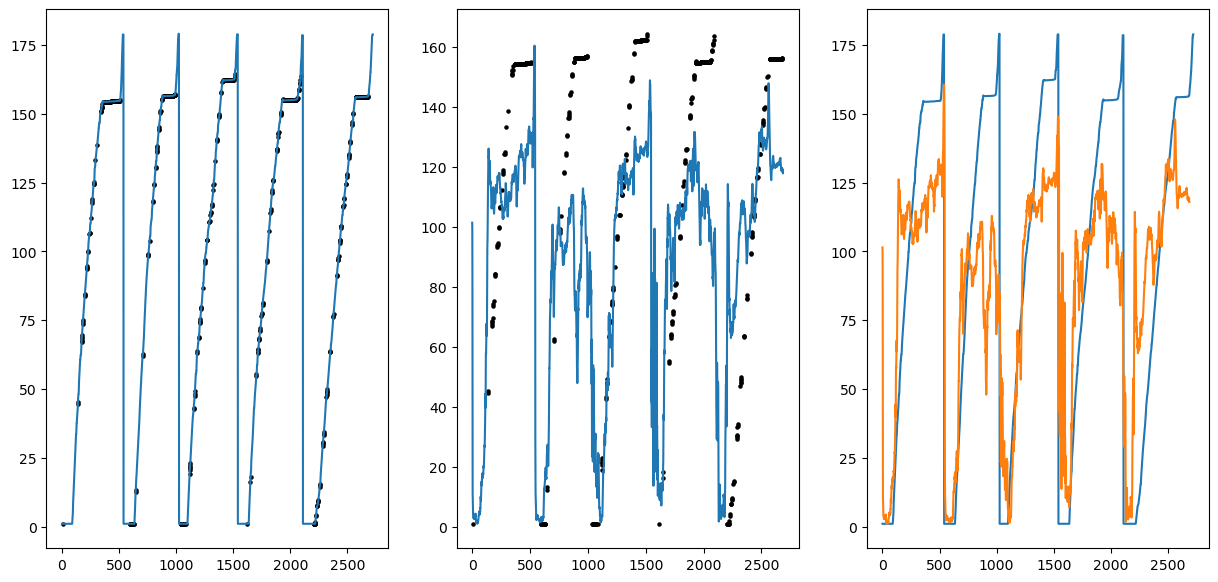

In [74]:
predict = np.concatenate([xx.cpu().detach().numpy() for xx in predict])
fig, axes = plt.subplots(1,3, figsize=(15,7))
axes[0].plot(pos)
axes[1].plot(predict)
axes[2].plot(pos)
axes[2].plot(predict)
axes[0].scatter(np.where(lick>0)[0], pos[np.where(lick>0)[0]], s=5, color='k')
axes[1].scatter(np.where(lick>0)[0], pos[np.where(lick>0)[0]], s=5, color='k')